In [1]:
import pickle as pkl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
tab = matplotlib.cm.get_cmap('tab10')
import pandas as pd
import sys
from glob import glob
from collections import defaultdict
import os

from itertools import groupby
import h5py

plt.rcParams['text.usetex'] = False
import pickle as pkl
from scipy.optimize import curve_fit

sys.path.append('../../code/')
from LAT_cluster_sim import diffusion_rate_Bessel

/tmp/ipykernel_27721/2479062192.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab = matplotlib.cm.get_cmap('tab10')


In [2]:
dt = 1.25e-4 #sec
dx = 0.03 #um

grid_size = 151

bind_weight_0 = 2.5
deg_weight_0 = 2

N_TCR = 2000 #based on BioNUmbers 100/um^2
k_on = 2.5e-5 # based on https://www.science.org/doi/10.1126/scisignal.aat8715 (Jay Groves paper)
               # and BioNumbers: 100 TCR/um^2
               # value calculated for a single TCR, with units of um^2/pMHC per second
pMHC_density_base = 0.5 #per um^2
k_off_base = 0.02 #based on MCC from same publication, units are per second

strength = [1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001]

k_create_0 = [120, 132, 92] #s^-1
k_create_1 = [12,  0,   40] #s^-1

types = {
    0:'Normal',
    1:'Small dt',
    2:'Y132F',
    3:'G135D'
}

factors = [3,12,1]
N_reps = 750
tot_jobs = 1000

N_per = np.array([[3,15,15,15,15,15,15],
                  [1, 3,10,30,15,15,15],
                  [6, 6, 6, 6, 6, 6, 6]]).astype(int)
N_job = (N_reps/N_per).astype(int)

print(N_job)
print(N_per)
print(N_per*N_job)
print(np.sum(N_job))

[[250  50  50  50  50  50  50]
 [750 250  75  25  50  50  50]
 [125 125 125 125 125 125 125]]
[[ 3 15 15 15 15 15 15]
 [ 1  3 10 30 15 15 15]
 [ 6  6  6  6  6  6  6]]
[[750 750 750 750 750 750 750]
 [750 750 750 750 750 750 750]
 [750 750 750 750 750 750 750]]
2675


In [3]:
TCR_density = N_TCR/(0.03*grid_size)**2 #TCR/um^2
tot = pMHC_density_base + TCR_density + (k_off_base/k_on)
base_frac_MHC = (tot - np.sqrt(tot**2 - 4*TCR_density*pMHC_density_base))/(2*TCR_density)
print(base_frac_MHC)

0.0005568503310903947


In [4]:
with open('cmds.sh','w') as f:

    for i in range(3):
        for ii,stg in enumerate(strength):

            pMHC_density = base_frac_MHC*(TCR_density - (k_off_base/(k_on*stg))/(base_frac_MHC-1))
            print(pMHC_density)
            
            kws = {'init_kws':{'source_locs':np.zeros([N_TCR,2]),  #only really specifying the number of TCRs here
                               'k_on_TCR':k_on,
                               'k_off_TCR':k_off_base/stg,
                               'pMHC_density':pMHC_density},

                   'diffusion_kws':{'D_LAT':0.043125, #um^2/s
                                    'dx':dx*1000}, #nm

                   'update_binding_kws':{'k_bind_max':  {0:3200,            1:3200}, # s^-1
                                         'k_bind_min':  {0:13.2,            1:35.2,},# s^-1
                                         'bind_infl':   {0:6*bind_weight_0, 1:6*bind_weight_0}, #max possible bonds = 30
                                         'k_unbind':    {0:3.66,            1:6.64e-3},# s^-1
                                         'bind_weights':{0:bind_weight_0,   1:bind_weight_0},
                                         'E_first':1, 'E_nth':0},

                   'update_exist_kws':{'D_TCR_free':0.064, #um^2/s
                                       'D_TCR_bound':0.0043, #um^2/s
                                       'dx':dx*1000, #nm
                                       'k_on_TCR':k_on,
                                       'k_off_TCR':k_off_base/stg,
                                       'pMHC_density':pMHC_density,
                                       'k_create_max_0':k_create_0[i], 'k_create_max_1':k_create_1[i], # s^-1
                                       'deg_weights':   {0:deg_weight_0,          1:4*deg_weight_0},
                                       'k_deactivate':2.8e-2, # s^-1
                                       'k_degrade_min':8e-3, # s^-1
                                       'k_degrade_max':5.3, # s^-1
                                       'degrade_infl':4*deg_weight_0},
                   'num_mols':{},
                   'cluster_size_distribution':{'max_cluster_size':1500},
                   'avg_mol_position':{},
                   'n_bound_TCR':{},
                   'n_active_TCR':{},
                   'n_bound_and_active_TCR':{},
                  }
            pkl.dump(kws, open(f'kws/type{i}_str{stg}_kws.pkl','wb'))

            for j in range(N_job[i,ii]):
                f.write(f'python ../../code/LAT_cluster_sim.py '+
                        f'-N {N_per[i,ii]} -T 120 -dt {dt} -grid_size {dx*grid_size} -dx {dx} '+\
                        f'-record_every_Nth {int(0.1/dt)} -N_save {int(j<5)} -write_every_Nth 100 '+
                        '-summary_funcs num_mols cluster_size_distribution avg_mol_position '+
                        'n_bound_TCR n_active_TCR n_bound_and_active_TCR '
                        '-binding_function binding_sigmoid_p_promiscuous '+
                        '-init_function initialize_random_source_locs_pre_eq_with_depletion '+
                        '-update_exist_function diffusing_fast_point_source_with_loss_negfdbk_and_depletion '+
                        '-diffusion_function diffusion_bessel_push '+
                        f'-kw_pkl kws/type{i}_str{stg}_kws.pkl '+
                        f'-outfile_base results/type{i}_str{stg}_{j}\n')

0.49999999999981765
1.540033094141372
4.511556220260099
14.911887161675644
44.62711842286291
148.63042783701837
445.7827404488911
0.49999999999981765
1.540033094141372
4.511556220260099
14.911887161675644
44.62711842286291
148.63042783701837
445.7827404488911
0.49999999999981765
1.540033094141372
4.511556220260099
14.911887161675644
44.62711842286291
148.63042783701837
445.7827404488911


In [5]:
complete = np.zeros([3,7,N_reps])
for i in range(3):
    for ii,stg in enumerate(strength):
        n = np.zeros([N_reps,1201])
        for j in range(N_job[i,ii]):
            try:
                times =  h5py.File(f'results/type{i}_str{stg}_{j}_summary_funcs.h5','r')['time'][:]
                n[j*N_per[i,ii]:(j+1)*N_per[i,ii],:] = times
            except FileNotFoundError:
                print(f'type{i}_str{stg}_{j}_summary_funcs.h5')
                pass

        complete[i,ii,:] = np.all(n[:,1:]>0,axis=1)

complete = complete.astype(bool)
print(N_reps - np.sum(complete,axis=2))

[[  0  24   9  89 151 166 146]
 [  0   0   0 195  10  63 149]
 [  0   0   0   0   0   0   0]]


In [10]:
N_reps_low = 500

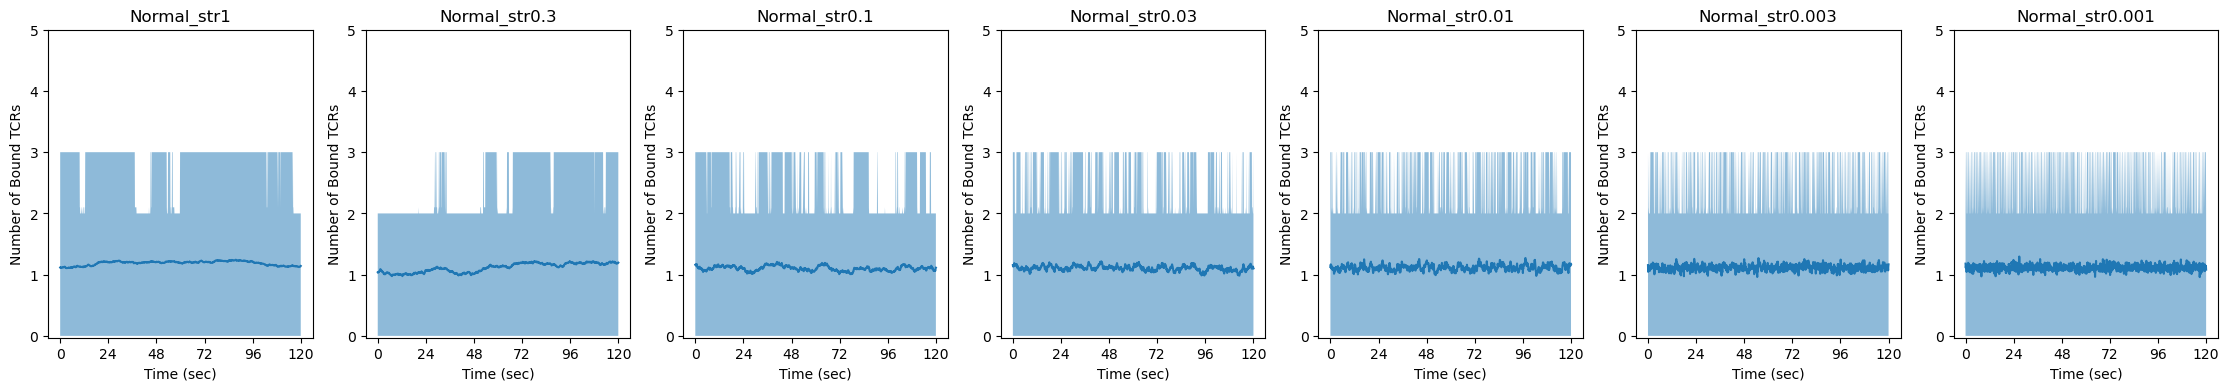

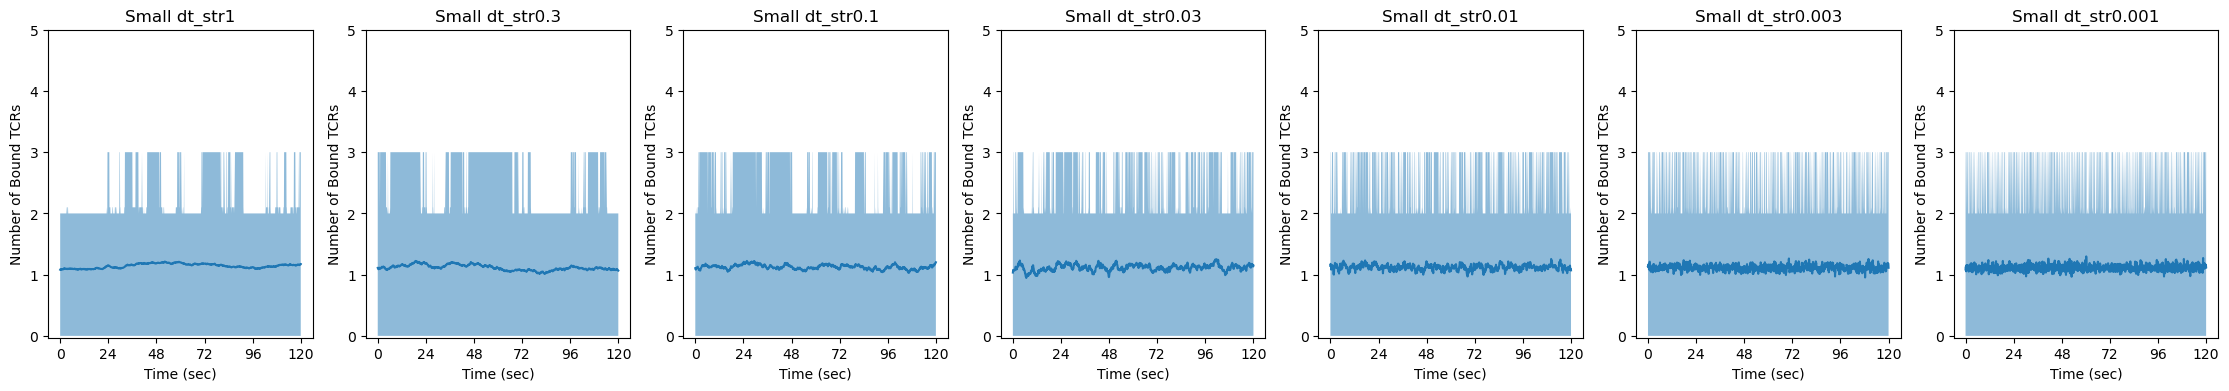

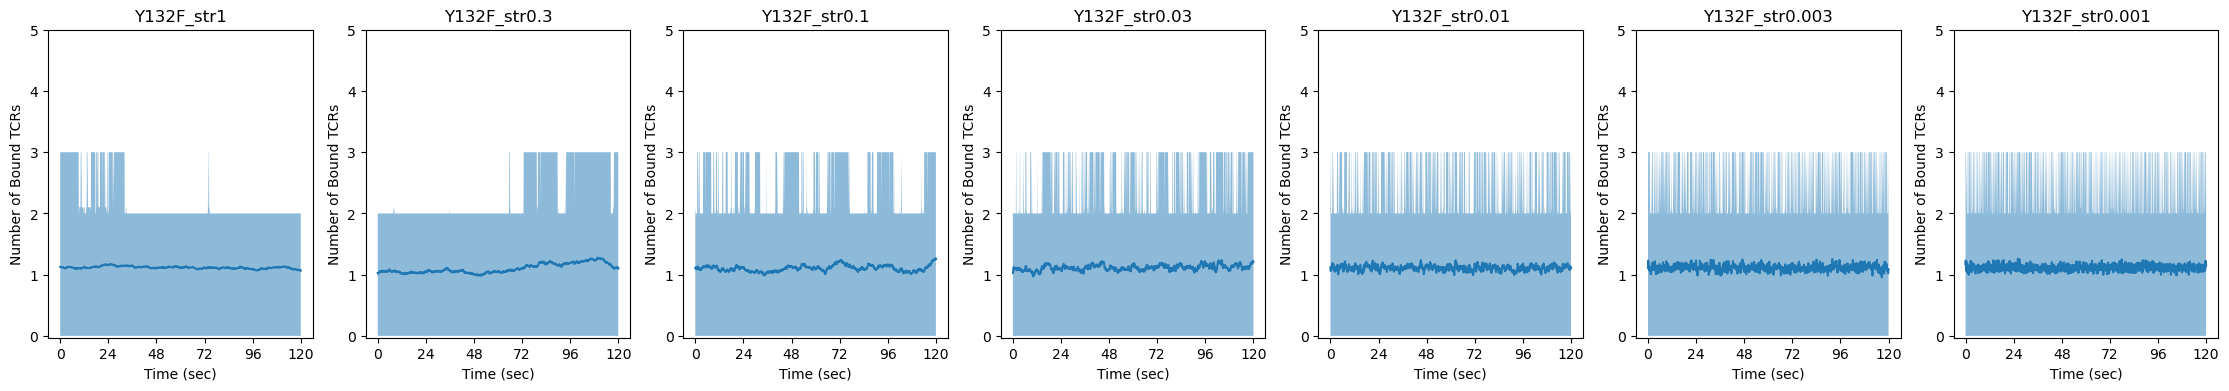

In [6]:
to_save = pd.DataFrame()
for i in range(3):
    plt.figure(figsize=[28,4])
    for ii,stg in enumerate(strength):
        plt.subplot(1,7,ii+1)

        n = np.zeros([N_reps,1201])
        for j in range(N_job[i,ii]):
            n[j*N_per[i,ii]:(j+1)*N_per[i,ii],:] = h5py.File(f'results/type{i}_str{stg}_{j}_summary_funcs.h5',
                                        'r')['n_bound_TCR'][:]
            
        n = n[complete[i,ii],:]
        n = n[:N_reps_low,:]

        n_mean = np.mean(n,0)
        n_low = np.quantile(n,0.1,axis=0)
        n_high = np.quantile(n,0.9,axis=0)
        
        to_save[f'type{i}_str{stg}_mean'] = n_mean
        to_save[f'type{i}_str{stg}_low'] = n_low
        to_save[f'type{i}_str{stg}_high'] = n_high

        plt.plot(range(1201),n_mean,label='Total')
        plt.fill_between(range(1201),n_low,n_high,alpha=0.5)

        plt.ylim([-0.03,5])
        plt.xticks(range(0,1201,240),np.linspace(0,120,6).astype(int))
        plt.xlabel('Time (sec)')
        plt.ylabel('Number of Bound TCRs')
        plt.title(f'{types[i]}_str{stg}')

to_save['time'] = np.array(range(1201))/10
to_save.to_csv('kp_n_bound_TCR.csv')

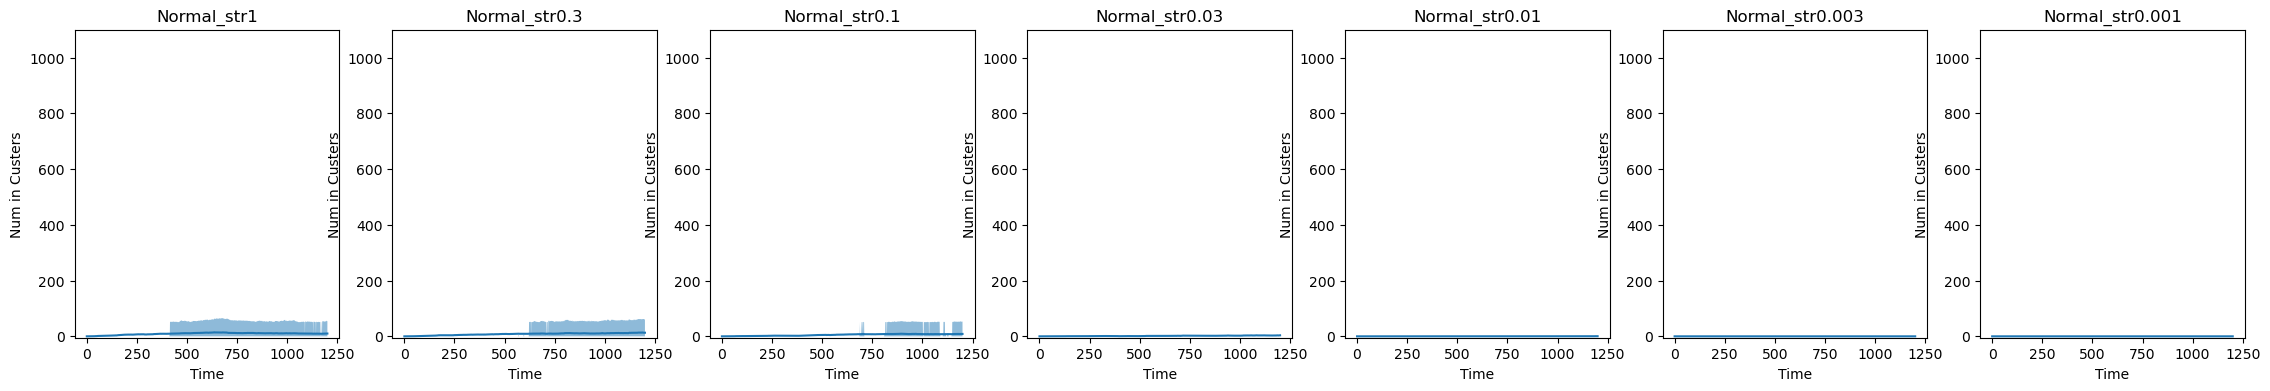

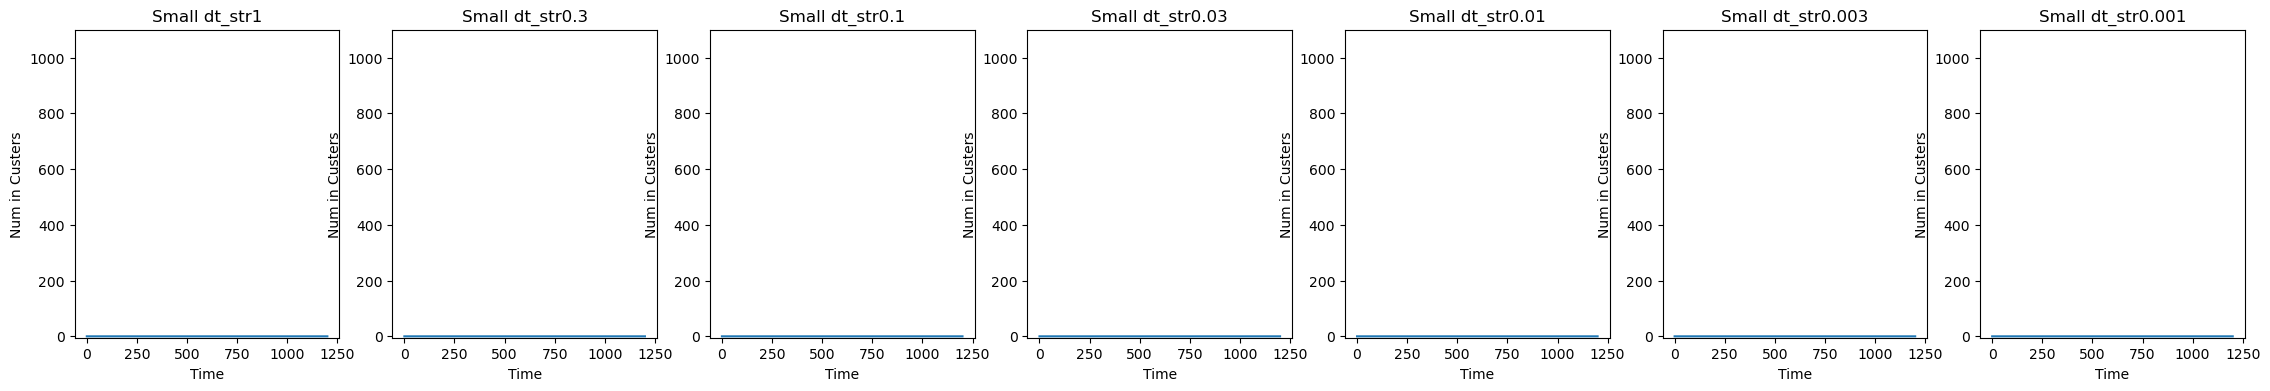

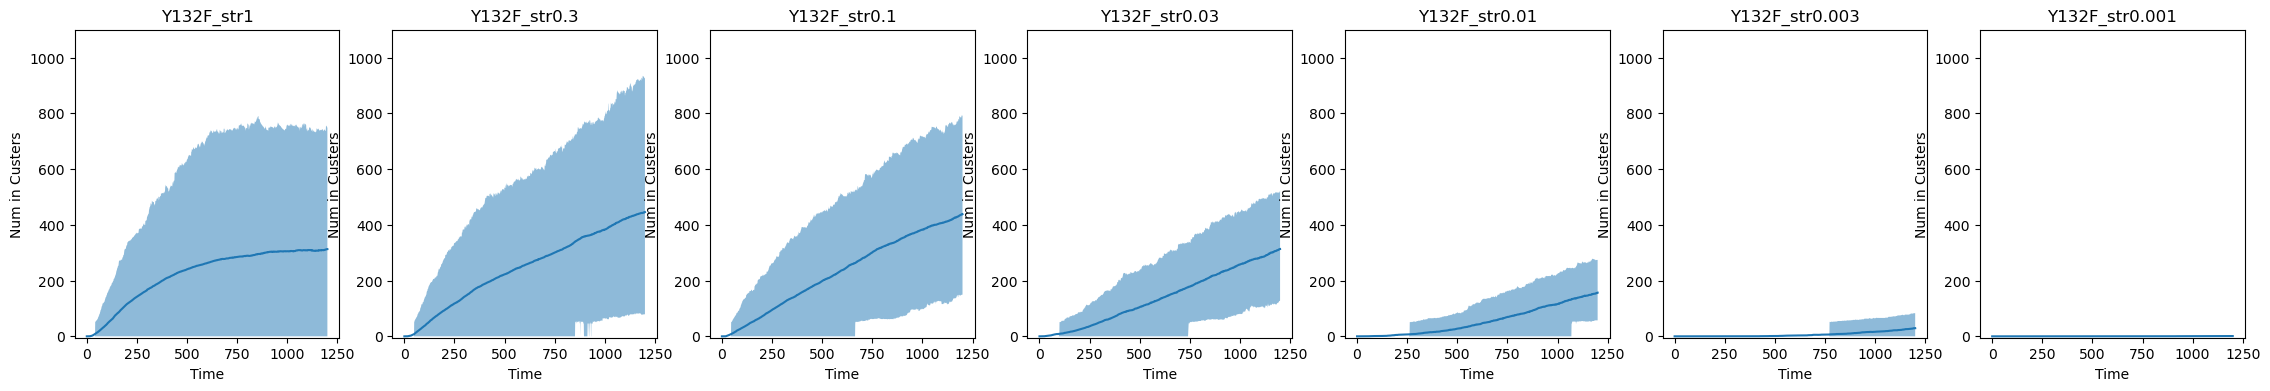

In [7]:
to_save = pd.DataFrame()
for i in range(3):
    plt.figure(figsize=[28,4])
    for ii,stg in enumerate(strength):
        plt.subplot(1,7,ii+1)

        size_distr = np.zeros([N_reps,1201,1500])
        n_mol = np.zeros([N_reps,1201])
        for j in range(N_job[i,ii]):
            size_distr[j*N_per[i,ii]:(j+1)*N_per[i,ii],:] = h5py.File(f'results/type{i}_str{stg}_{j}_summary_funcs.h5',
                                         'r')['cluster_size_distribution'][:]
            n_mol[j*N_per[i,ii]:(j+1)*N_per[i,ii],:] = h5py.File(f'results/type{i}_str{stg}_{j}_summary_funcs.h5',
                                         'r')['num_mols'][:]
        size_distr = size_distr[complete[i,ii],:]
        size_distr = size_distr[:N_reps_low,:]
        
        n_mol = n_mol[complete[i,ii],:]
        n_mol = n_mol[:N_reps_low,:]

        n_clust = np.sum(size_distr[:,:,50:],axis=2)*n_mol
        
        n_clust_mean = np.mean(n_clust,0)
        n_clust_low = np.quantile(n_clust,0.1,axis=0)
        n_clust_high = np.quantile(n_clust,0.9,axis=0)
        
        to_save[f'type{i}_str{stg}_mean'] = n_clust_mean
        to_save[f'type{i}_str{stg}_low'] = n_clust_low
        to_save[f'type{i}_str{stg}_high'] = n_clust_high
            
        plt.plot(range(1201),n_clust_mean,label='Total')
        plt.fill_between(range(1201),n_clust_low,n_clust_high,alpha=0.5)
        
        if i == 2:
            plt.ylim([-5,1100])
        else:
            plt.ylim([-5,1100])

        plt.xlabel('Time')
        plt.ylabel('Num in Custers')
        plt.title(f'{types[i]}_str{stg}')
to_save['time'] = np.array(range(1201))/10
to_save.to_csv('kp_max_clustered_time.csv')

/tmp/ipykernel_27721/4198305190.py:13: RuntimeWarning: divide by zero encountered in log10
  sns.heatmap(np.log10(np.mean(size_distr,axis=0)).T,mask=np.mean(size_distr,axis=0).T==0,vmax=0,cbar=False)
/tmp/ipykernel_27721/4198305190.py:13: RuntimeWarning: divide by zero encountered in log10
  sns.heatmap(np.log10(np.mean(size_distr,axis=0)).T,mask=np.mean(size_distr,axis=0).T==0,vmax=0,cbar=False)
/tmp/ipykernel_27721/4198305190.py:13: RuntimeWarning: divide by zero encountered in log10
  sns.heatmap(np.log10(np.mean(size_distr,axis=0)).T,mask=np.mean(size_distr,axis=0).T==0,vmax=0,cbar=False)
/tmp/ipykernel_27721/4198305190.py:13: RuntimeWarning: divide by zero encountered in log10
  sns.heatmap(np.log10(np.mean(size_distr,axis=0)).T,mask=np.mean(size_distr,axis=0).T==0,vmax=0,cbar=False)
/tmp/ipykernel_27721/4198305190.py:13: RuntimeWarning: divide by zero encountered in log10
  sns.heatmap(np.log10(np.mean(size_distr,axis=0)).T,mask=np.mean(size_distr,axis=0).T==0,vmax=0,cbar=False)


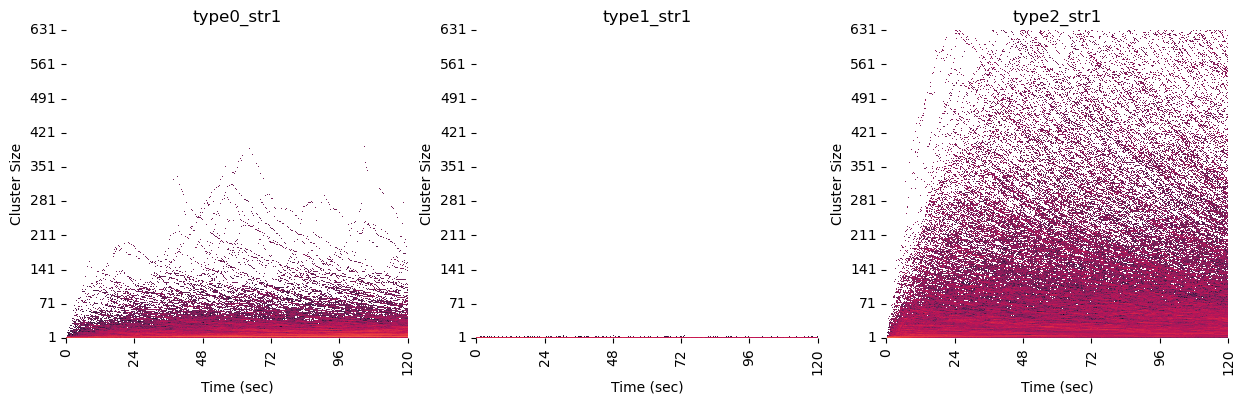

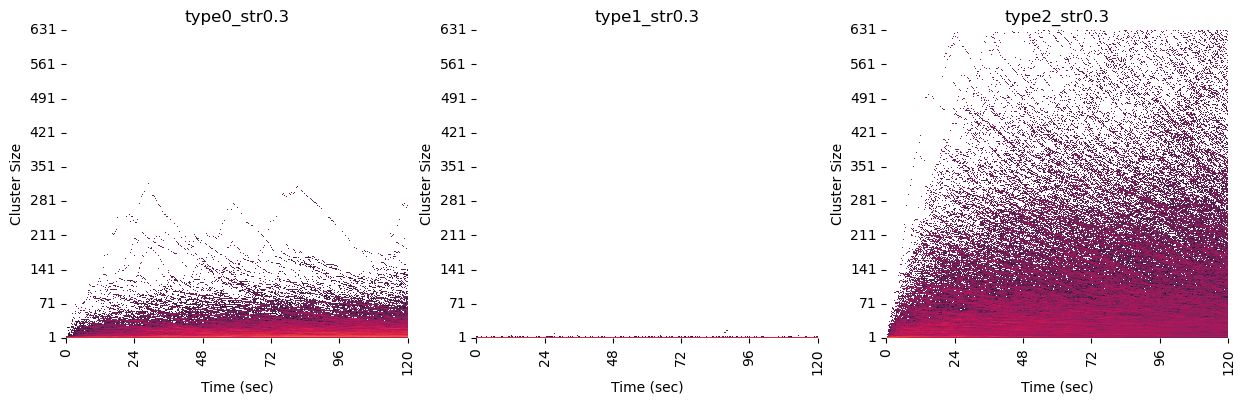

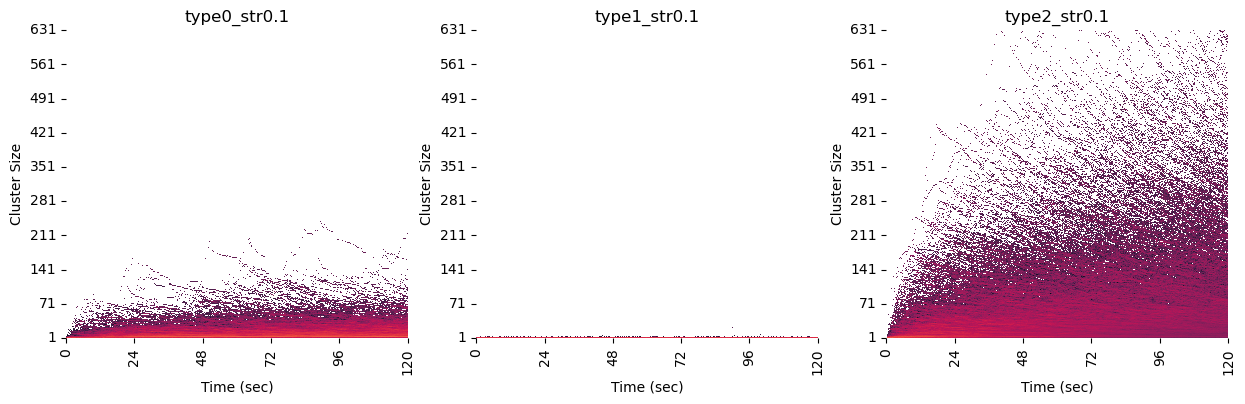

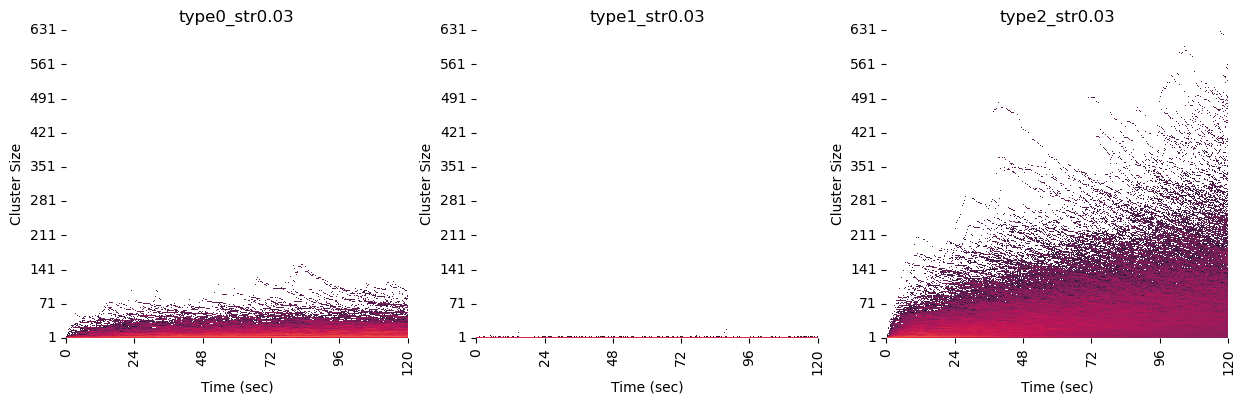

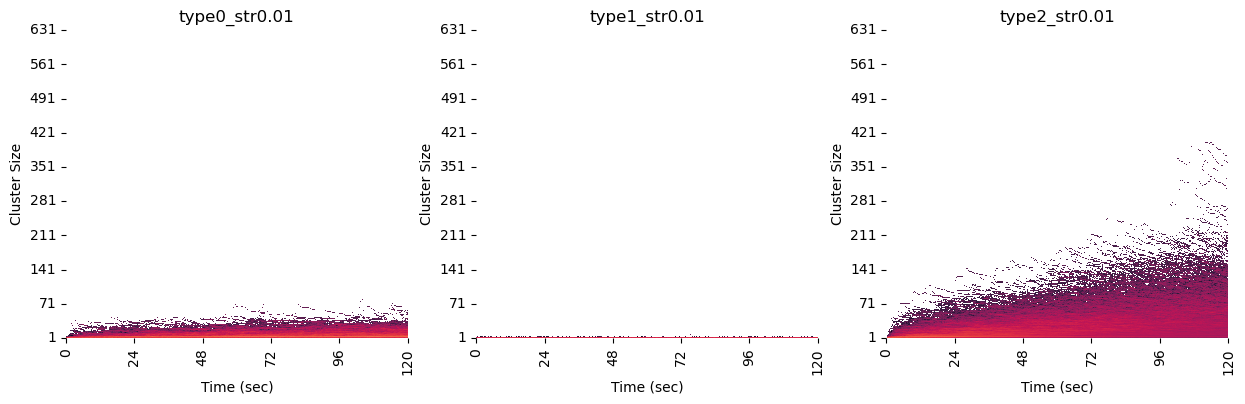

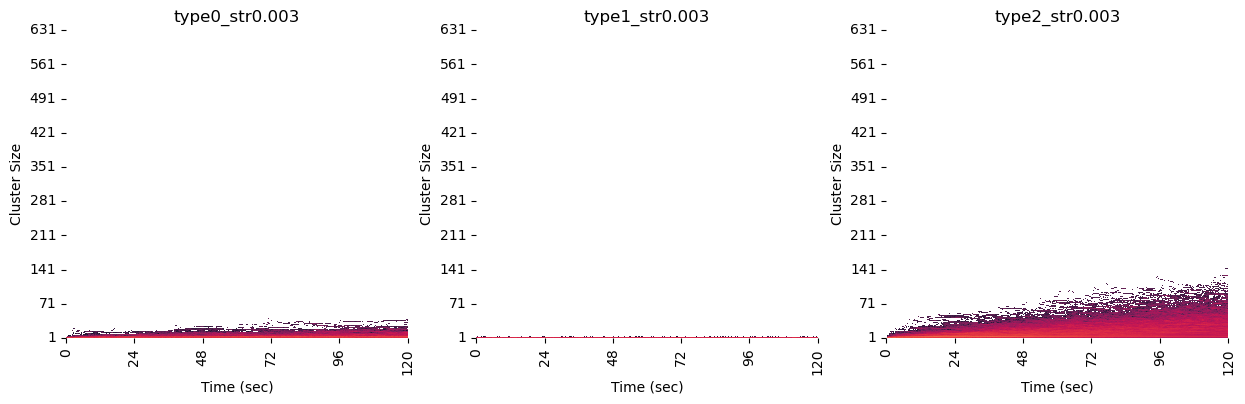

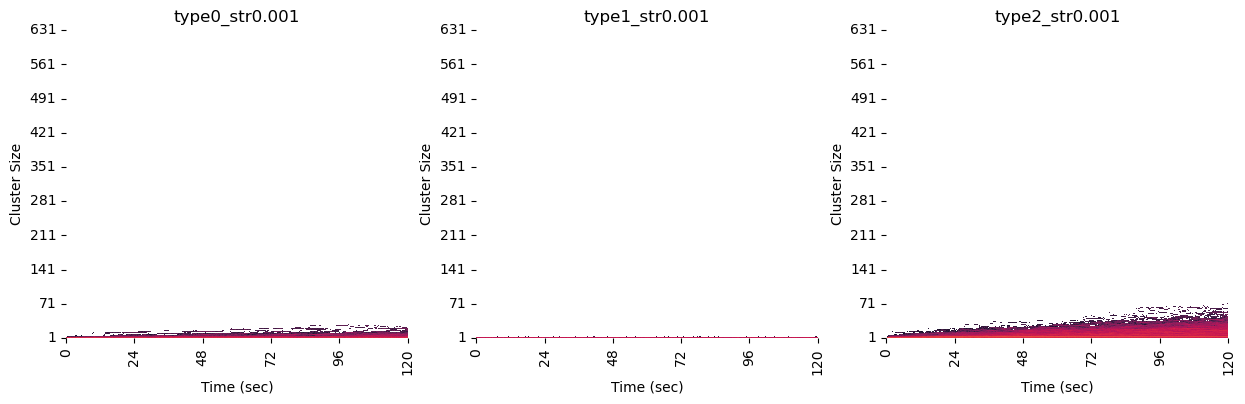

In [8]:
for ii,stg in enumerate(strength):
    plt.figure(figsize=[15,4])
    for i,ty in enumerate(range(3)):
        plt.subplot(1,3,i+1)
    
        size_distr = np.zeros([N_reps,1201,1500])
        for j in range(N_job[i,ii]):
            size_distr[j*N_per[i,ii]:(j+1)*N_per[i,ii],:] = h5py.File(f'results/type{ty}_str{stg}_{j}_summary_funcs.h5',
                                         'r')['cluster_size_distribution'][:]
        size_distr = size_distr[complete[i,ii],:]
        size_distr = size_distr[:N_reps_low,:]
    
        sns.heatmap(np.log10(np.mean(size_distr,axis=0)).T,mask=np.mean(size_distr,axis=0).T==0,vmax=0,cbar=False)
    
        plt.xticks(range(0,1201,240),np.linspace(0,120,6).astype(int))
        plt.xlabel('Time (sec)')
        plt.ylabel('Cluster Size')
        plt.ylim([0,500])
        plt.yticks(range(0,700,70),range(1,701,70))
        plt.title(f'type{ty}_str{stg}')

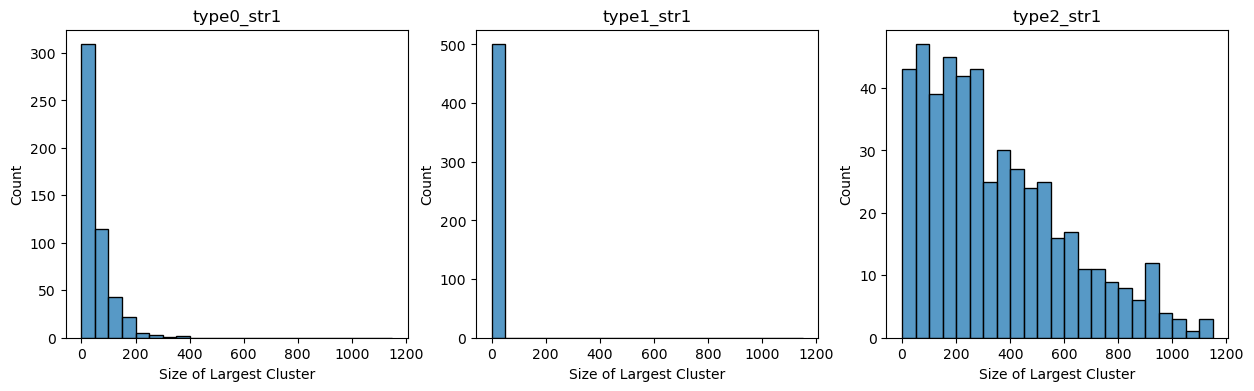

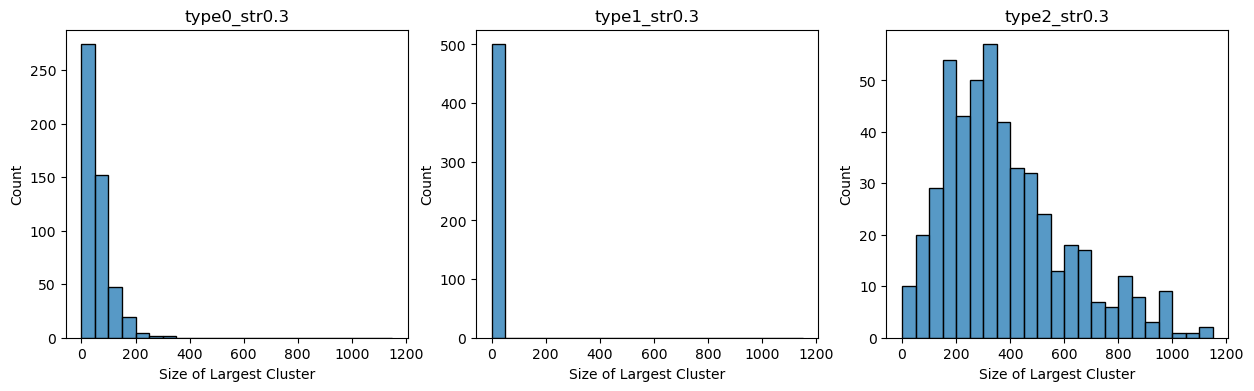

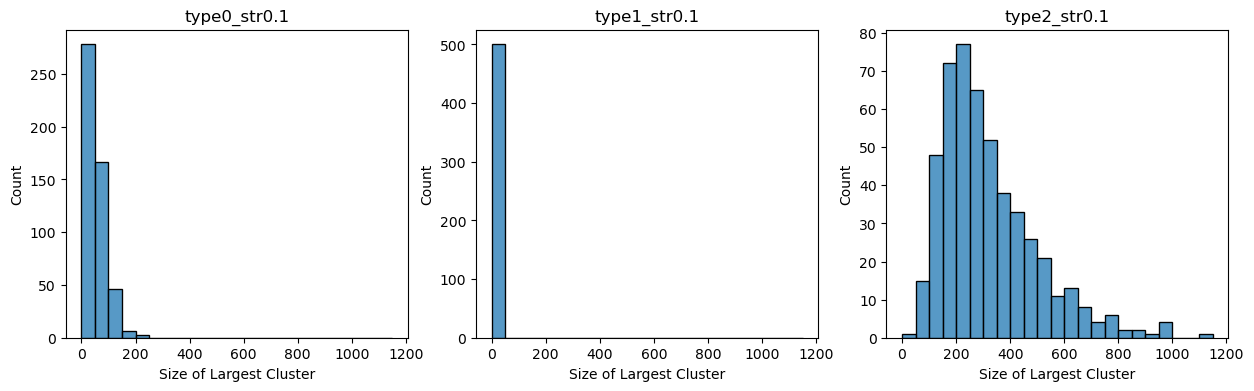

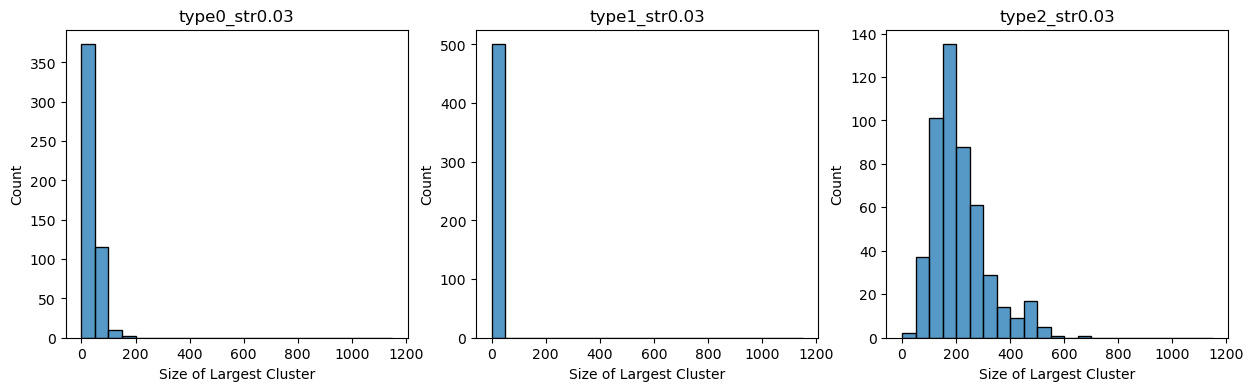

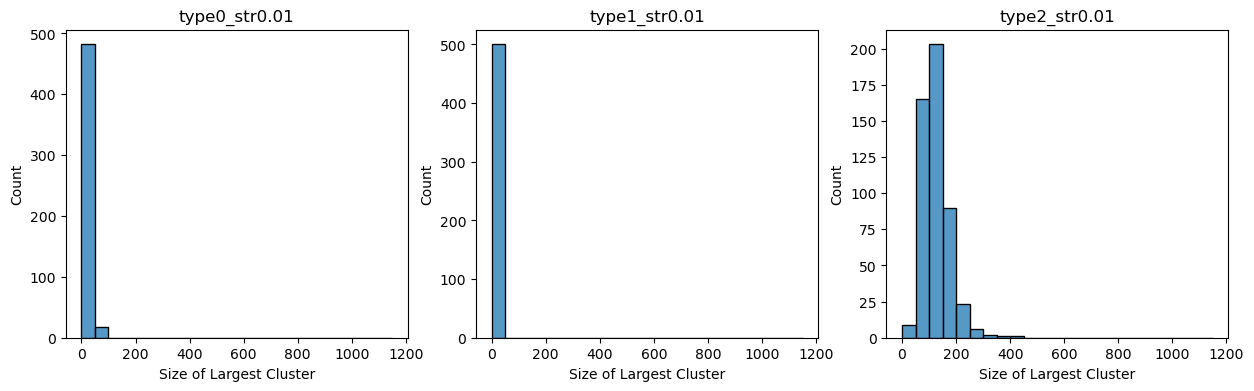

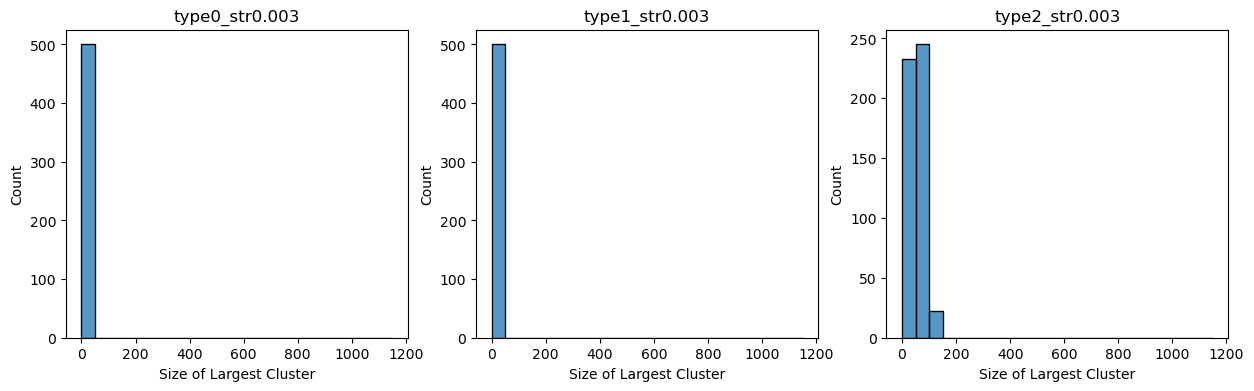

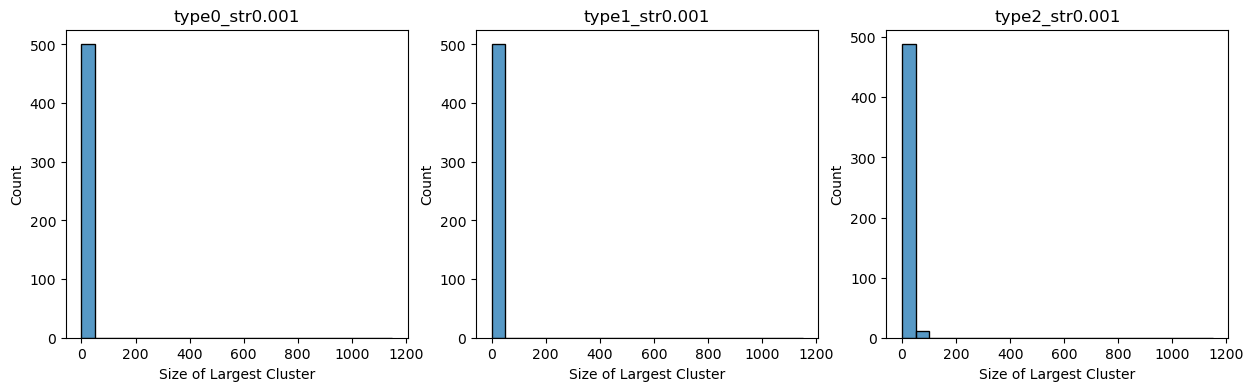

In [15]:
to_save = pd.DataFrame()
for ii,stg in enumerate(strength):
    plt.figure(figsize=[15,4])
    for i,ty in enumerate(range(3)):
        plt.subplot(1,3,i+1)
    
        size_distr = np.zeros([N_reps,1201,1500])
        for j in range(N_job[i,ii]):
            size_distr[j*N_per[i,ii]:(j+1)*N_per[i,ii],:] = h5py.File(f'results/type{ty}_str{stg}_{j}_summary_funcs.h5',
                                         'r')['cluster_size_distribution'][:]
        size_distr = size_distr[complete[i,ii],:]
        size_distr = size_distr[:N_reps_low,:]
    
        cluster_size = np.tile(np.array(range(1,1501)).reshape([1,1500]),[1201,1])
        where_cluster = size_distr > 0
        max_cluster_sizes = np.zeros([size_distr.shape[0]])
        for j in range(size_distr.shape[0]):
            sim_clusters = where_cluster[j,:,:]
            sim_clusters = cluster_size*sim_clusters
            max_cluster_sizes[j] = np.max(np.max(sim_clusters,axis=1),axis=0)
    
        to_save[f'type{ty}_str{stg}'] = np.zeros([N_reps_low])
        to_save.loc[:N_reps_low,f'type{ty}_str{stg}'] = max_cluster_sizes
    
        sns.histplot(max_cluster_sizes,bins=range(0,1200,50))
    
        plt.xlabel('Size of Largest Cluster')
        plt.ylabel('Count')
        plt.title(f'type{ty}_str{stg}')

to_save.to_csv('kp_largest_cluster.csv')

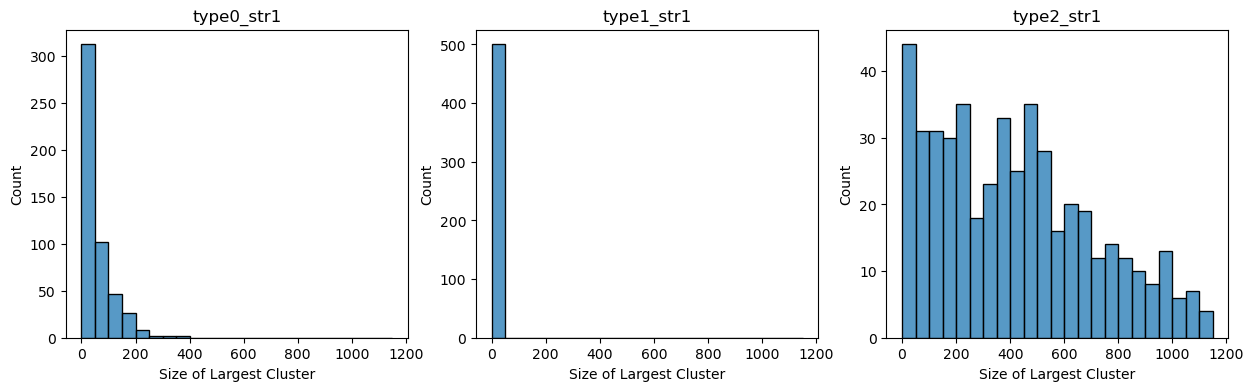

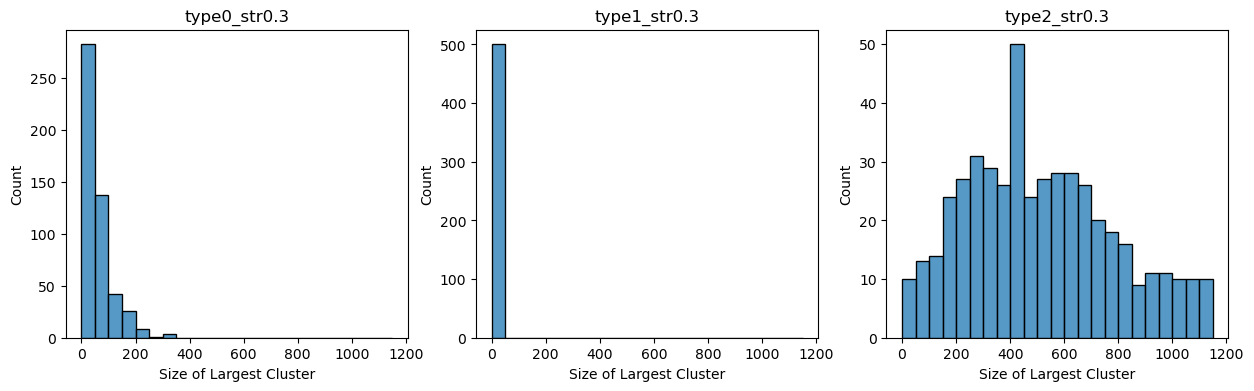

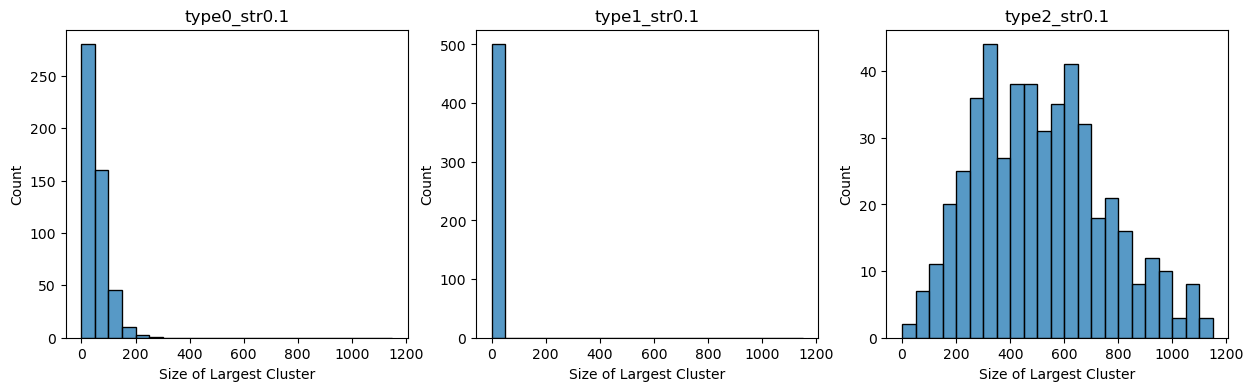

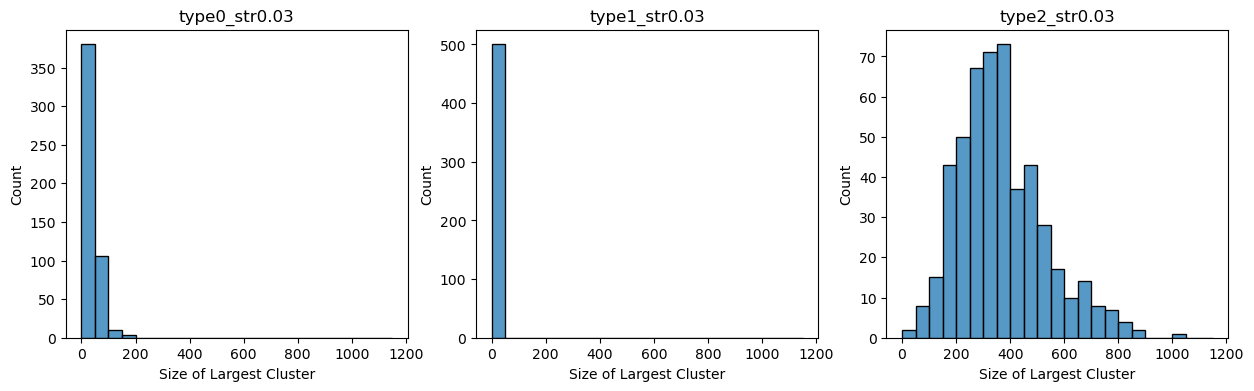

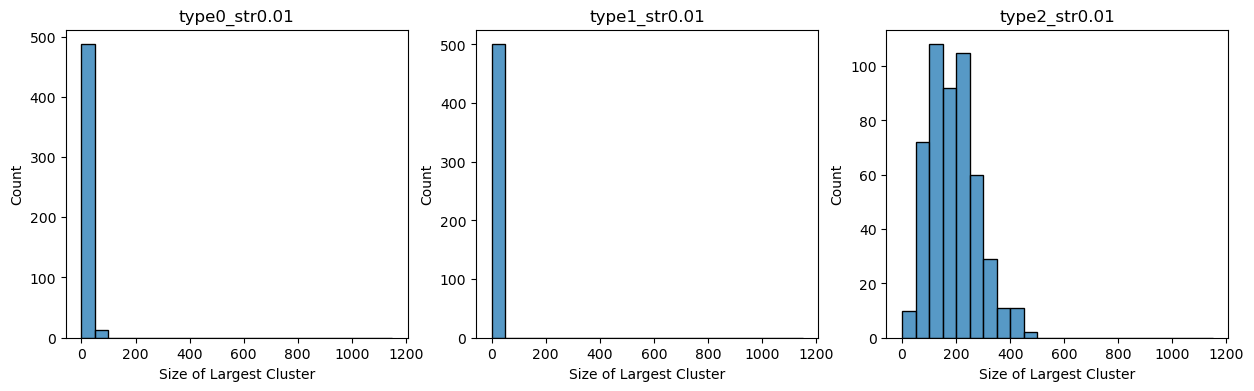

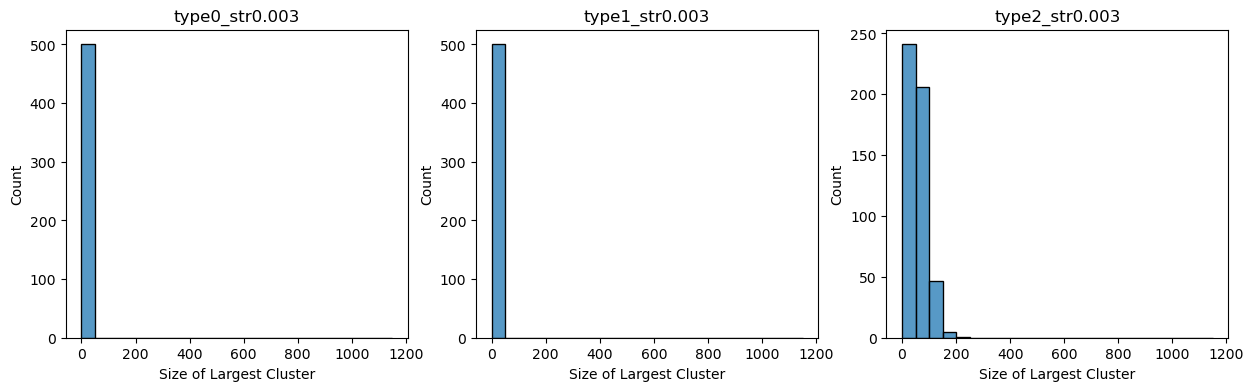

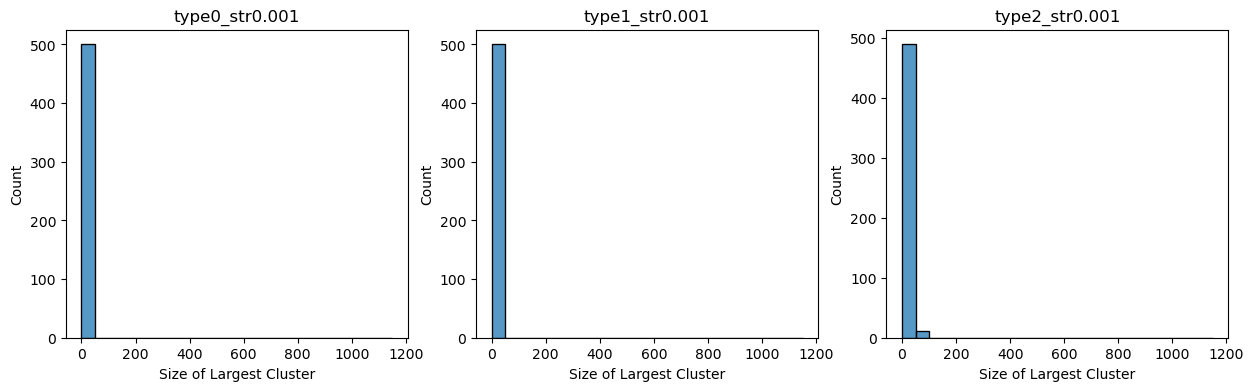

In [16]:
to_save = pd.DataFrame()
for ii,stg in enumerate(strength):
    plt.figure(figsize=[15,4])
    for i,ty in enumerate(range(3)):
        plt.subplot(1,3,i+1)
    
        size_distr = np.zeros([N_reps,1201,1500])
        n_mol = np.zeros([N_reps,1201])
        for j in range(N_job[i,ii]):
            size_distr[j*N_per[i,ii]:(j+1)*N_per[i,ii],:] = h5py.File(f'results/type{ty}_str{stg}_{j}_summary_funcs.h5',
                                         'r')['cluster_size_distribution'][:]
            n_mol[j*N_per[i,ii]:(j+1)*N_per[i,ii],:] = h5py.File(f'results/type{ty}_str{stg}_{j}_summary_funcs.h5',
                                         'r')['num_mols'][:]
        size_distr = size_distr[complete[i,ii],:]
        size_distr = size_distr[:N_reps_low,:]
        
        n_mol = n_mol[complete[i,ii],:]
        n_mol = n_mol[:N_reps_low,:]
    
        n_clust = np.max(np.sum(size_distr[:,:,50:],axis=2)*n_mol,axis=1)
    
        to_save[f'type{ty}_str{stg}'] = np.zeros([N_reps_low])
        to_save.loc[:N_reps_low,f'type{ty}_str{stg}'] = n_clust
    
        sns.histplot(n_clust,bins=range(0,1200,50))
    
        plt.xlabel('Size of Largest Cluster')
        plt.ylabel('Count')
        plt.title(f'type{ty}_str{stg}')
to_save.to_csv('kp_max_clustered_distr.csv')

In [17]:
frac_clust = np.zeros([3,7])

for i,ty in enumerate(range(3)):
    for ii,stg in enumerate(strength):
        size_distr = np.zeros([N_reps,1201,1500])
        for j in range(N_job[i,ii]):
            size_distr[j*N_per[i,ii]:(j+1)*N_per[i,ii],:] = h5py.File(f'results/type{ty}_str{stg}_{j}_summary_funcs.h5',
                                         'r')['cluster_size_distribution'][:]
        size_distr = size_distr[complete[i,ii],:]
        size_distr = size_distr[:N_reps_low,:]
    
        has_cluster = np.sum(np.sum(size_distr[:,:,50:],axis=2),axis=1).astype(bool)
        frac_clust[i,ii] = np.mean(has_cluster)
        
to_save.to_csv('kp_frac_clust.csv')
print(frac_clust)

[[0.376 0.436 0.44  0.24  0.026 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.912 0.98  0.996 0.996 0.98  0.518 0.022]]


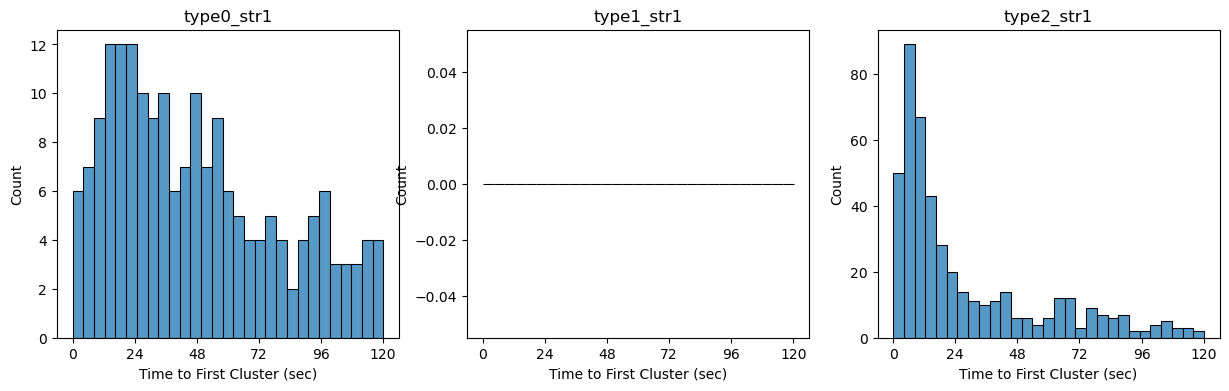

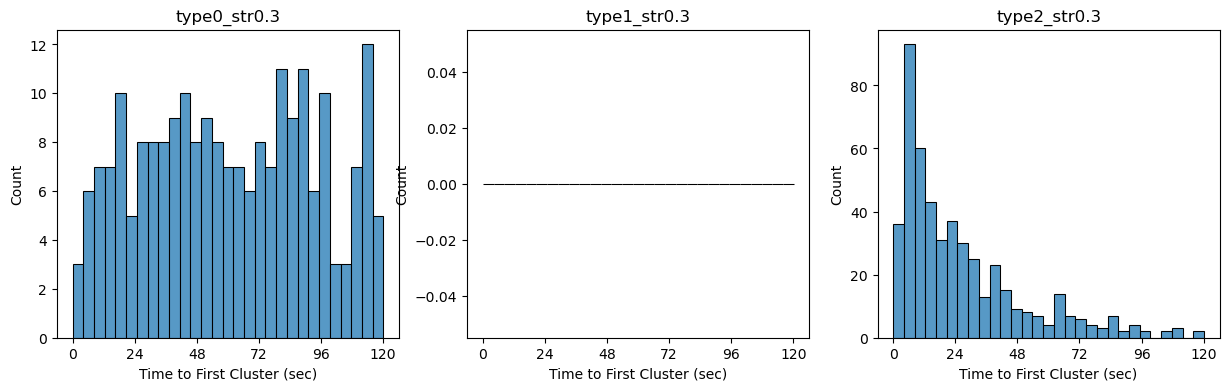

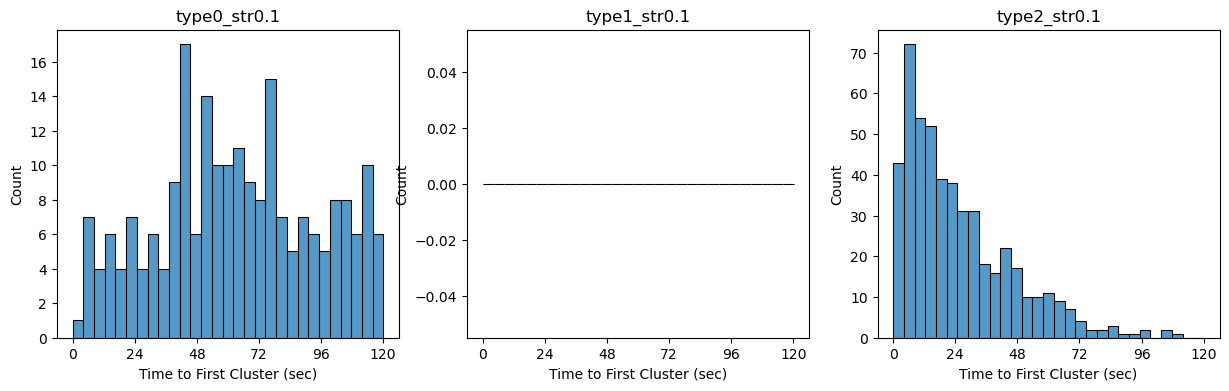

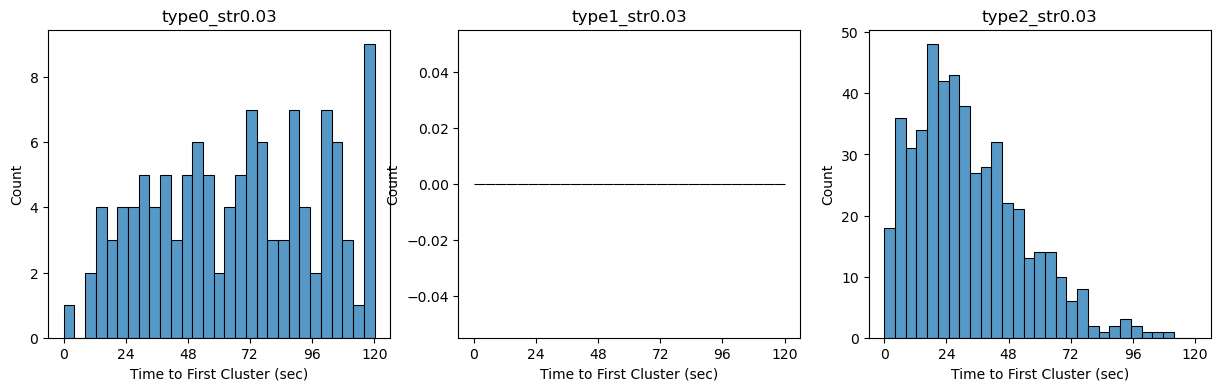

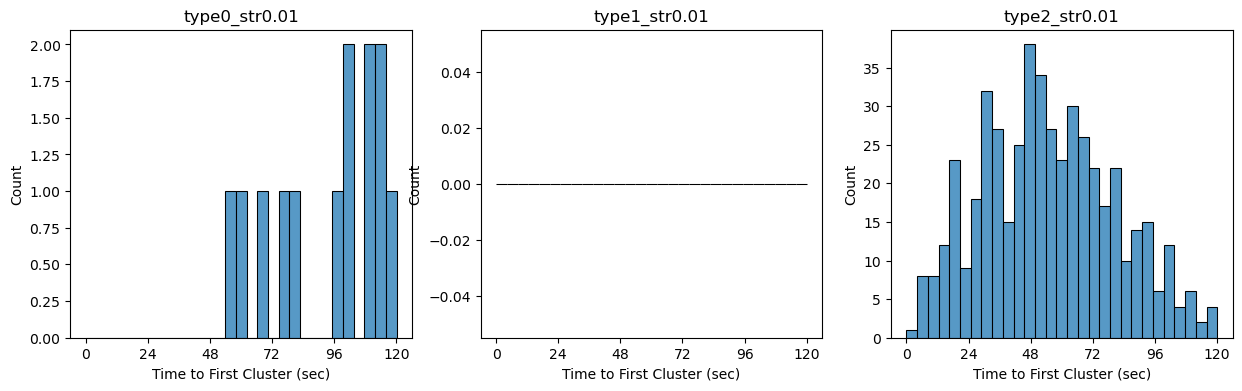

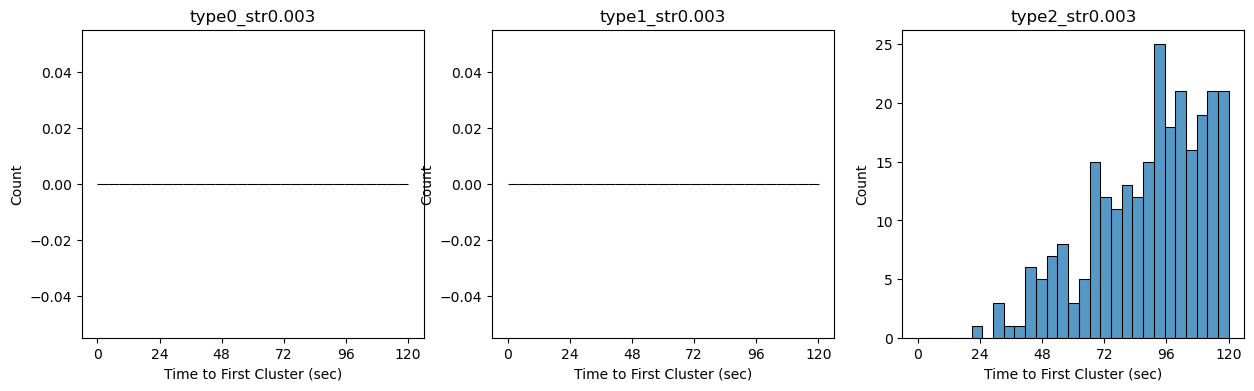

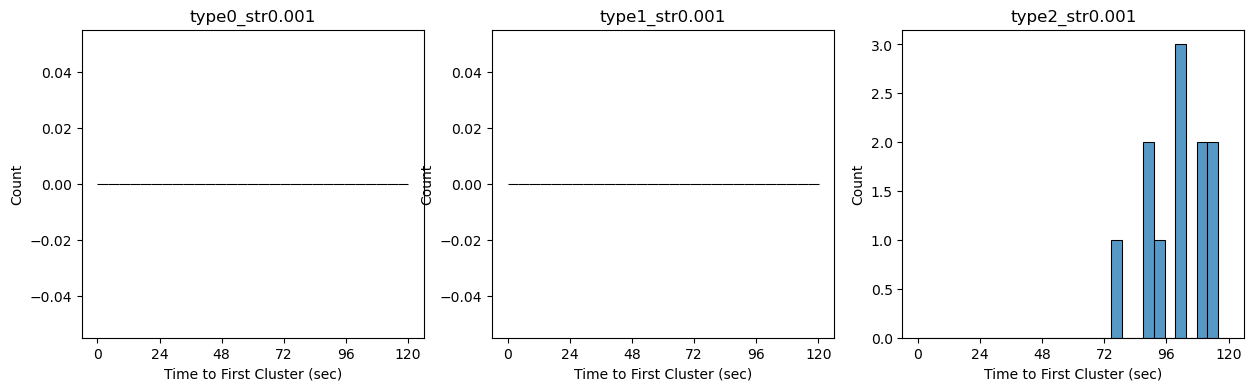

In [18]:
to_save = pd.DataFrame()
for ii,stg in enumerate(strength):
    plt.figure(figsize=[15,4])
    for i,ty in enumerate(range(3)):
        plt.subplot(1,3,i+1)
    
        size_distr = np.zeros([N_reps,1201,1500])
        for j in range(N_job[i,ii]):
            size_distr[j*N_per[i,ii]:(j+1)*N_per[i,ii],:] = h5py.File(f'results/type{ty}_str{stg}_{j}_summary_funcs.h5',
                                         'r')['cluster_size_distribution'][:]
        size_distr = size_distr[complete[i,ii],:]
        size_distr = size_distr[:N_reps_low,:]
    
        has_cluster = np.sum(size_distr[:,:,50:],axis=2).astype(bool)
        cluster_locs = np.where(has_cluster)
        init_time = np.zeros([size_distr.shape[0]])
    
        for t in range(size_distr.shape[0]):
            if np.sum(cluster_locs[0]==t):
                init_time[t] = cluster_locs[1][cluster_locs[0]==t][0]
            else:
                init_time[t] = np.NaN
    
        to_save[f'type{ty}_str{stg}'] = np.zeros([N_reps_low])
        to_save.loc[:N_reps_low,f'type{ty}_str{stg}'] = init_time
    
        sns.histplot(init_time, bins=np.linspace(0,1201,30))
        plt.xticks(range(0,1201,240),np.linspace(0,120,6).astype(int))
        plt.xlabel('Time to First Cluster (sec)')
        plt.ylabel('Count')
        plt.title(f'type{ty}_str{stg}')
to_save.to_csv('kp_init_time.csv')